# Angular Power Spectrum

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
from glob import glob

In [5]:
import matplotlib.pyplot as plt
from time import time
import numpy as np
from modules import (bias_model, dNdz_model, 
                     init_sample, Spectrum)
import os
import sys
sys.path.append('/home/mehdi/github/LSSutils')
from lssutils.dataviz import setup_color
import fitsio as ft
import healpy as hp
import lssutils.utils as ut
import pandas as pd
### compute cross correlation of the data
from lssutils.lab import get_cl, maps_dr9sv3
from lssutils.lab import histogram_cell

setup_color()

def run_anafast(map1, mask):
    map1_ = hp.ma(map1)
    map1_.mask = np.logical_not(mask)
    return hp.anafast(map1_.filled(), pol=False)

## Model Power Spectrum


### Mock

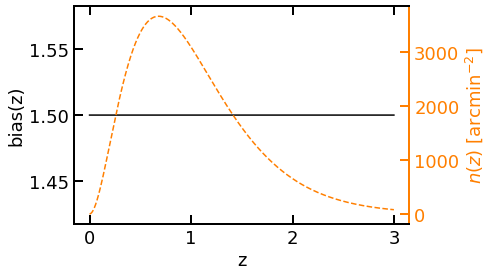

In [5]:
z, b, dNdz = init_sample(kind='mock', plot=True)

In [6]:
Om_b = 0.048206
Om_cdm = 0.307115 - Om_b
model = Spectrum(h=0.6777, Omega0_b=Om_b, Omega0_cdm=Om_cdm, n_s=0.9611, sigma8=0.8225)

h         : 0.6777
T0_cmb    : 2.7255
Omega0_b  : 0.048206
Omega0_cdm: 0.25890900000000006
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9611
nonlinear : False


(7.841288000109608e-08, 2e-05)

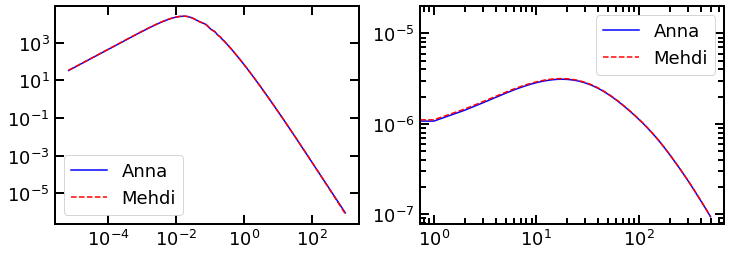

In [9]:
ell = np.arange(500)
model.add_tracer(z, b, dNdz, p=1.6)
model.make_kernels(ell)
cell_mr = model(ell)



# Pk
pk_anna = np.loadtxt('Pk_z0_linear.txt')
cl_anna = np.loadtxt('C_ells_bin1_1_linear.txt')
pk_mr = model.Plin(pk_anna[:, 0])


# test MR with AP
fg, ax = plt.subplots(ncols=2, figsize=(12, 4))

ax[0].loglog(pk_anna[:, 0], pk_anna[:, 1], 'b-',
           pk_anna[:, 0], pk_mr, 'r--')
ax[0].legend(['Anna', 'Mehdi'])  




ax[1].loglog(cl_anna[:, 0], cl_anna[:, 1], 'b-',
           ell, cell_mr, 'r--')
ax[1].legend(['Anna', 'Mehdi'])  
ax[1].set_ylim(ymax=2.0e-5)

## Bias and Redshift Evolution

### QSO

Text(0.5, 0, 'z')

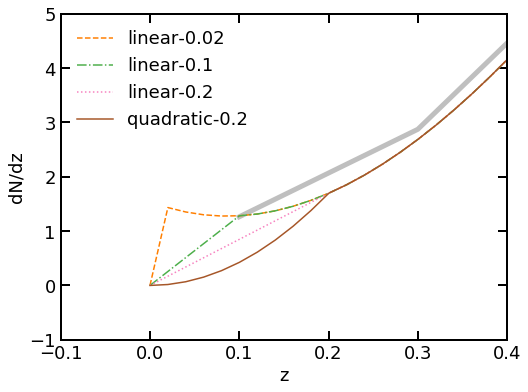

In [9]:
z1, dNdz1 = dNdz_model(z_low=0.02)
z2, dNdz2 = dNdz_model(z_low=0.2)
z3, dNdz3 = dNdz_model(z_low=0.2, kind=2)
z4, dNdz4 = dNdz_model(z_low=0.1)

nz_, z_ = np.loadtxt('/home/mehdi/data/dr9v0.57.0/p38fnl/RF_g.txt').T

assert np.array_equal(z1, z2)
b = bias_model(z1)


plt.figure(figsize=(8, 6))
plt.plot(z_, nz_, lw=5, alpha=0.5, color='grey')

plt.plot(z1, dNdz1, label='linear-0.02')
plt.plot(z4, dNdz4, label='linear-0.1')
plt.plot(z2, dNdz2, label='linear-0.2')
plt.plot(z3, dNdz3, label='quadratic-0.2')

plt.xlim(-0.1, 0.4)
plt.ylim(-1., 5.)
plt.legend(frameon=False)
plt.ylabel('dN/dz')
plt.xlabel('z')

Text(0, 0.5, 'C$_{X}$/C$_{\\rm linear-0.2}$')

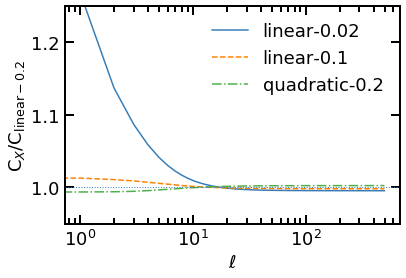

In [14]:
model = Spectrum()

ell = np.arange(500)
t0 = time()
model.add_tracer(z1, b, dNdz1)
model.make_kernels(ell)
cell1 = model(ell)
t1 = time()
print('time', t1-t0)

model.add_tracer(z2, b, dNdz2)
model.make_kernels(ell)
cell2 = model(ell)

model.add_tracer(z3, b, dNdz3)
model.make_kernels(ell)
cell3 = model(ell)

model.add_tracer(z4, b, dNdz4)
model.make_kernels(ell)
cell4 = model(ell)

plt.plot(ell, cell1/cell2, label='linear-0.02')
# plt.loglog(ell, cell2, label='linear-0.2')
plt.plot(ell, cell4/cell2, label='linear-0.1')
plt.plot(ell, cell3/cell2, label='quadratic-0.2')
plt.legend(frameon=False)
plt.axhline(1.0, ls=':', lw=1)
plt.semilogx()
plt.ylim(0.95, 1.25)
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{X}$/C$_{\rm linear-0.2}$')

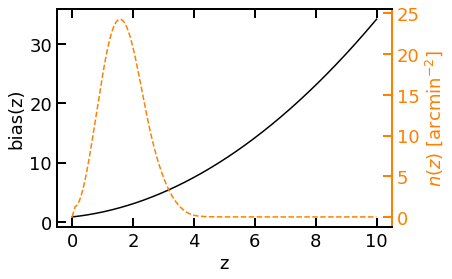

In [10]:
z, b, dNdz = init_sample(kind='qso', plot=True)

In [11]:
model = Spectrum()

ell = np.arange(500)
model.add_tracer(z, b, dNdz, p=1.6)
model.make_kernels(ell)

cells = {}
for fnl in [-100, -10.0, 0.0, 10.0, 100]:
    cells[fnl] = model(ell, fnl=fnl)

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False


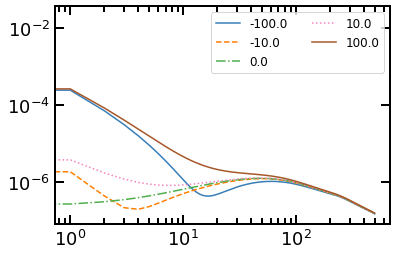

In [14]:
for fnl, cell in cells.items():
    plt.loglog(cell, label=f'{fnl:.1f}')
plt.legend(fontsize=12, ncol=2)

## Generate Mocks

In [5]:
z, b, dNdz = init_sample(kind='qso')

model = Spectrum()

ell = np.arange(3000)
model.add_tracer(z, b, dNdz, p=1.6)
model.make_kernels(ell)

cl_true = model(ell, fnl=0.0)

h         : 0.67556
T0_cmb    : 2.7255
Omega0_b  : 0.0482754208891869
Omega0_cdm: 0.26377065934278865
N_ur      : None
m_ncdm    : [0.06]
P_k_max   : 10.0
P_z_max   : 100.0
sigma8    : 0.8225
gauge     : synchronous
n_s       : 0.9667
nonlinear : False


In [34]:
region = 'NBMZLS'
dcat_ = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/sv3target_QSO_{region}.fits')
rcat_ = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/{region}_randoms-1-0x5.fits')
wsys_ = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/sv3target_QSO_{region}.fits_EdWsys/wsys_v0.fits')['wsys']

bits = [1, 5, 6, 7, 8, 9, 11, 12, 13] # https://www.legacysurvey.org/dr9/bitmasks/
dcat, ix = ut.cutphotmask(dcat_, bits, return_indices=True)
rcat = ut.cutphotmask(rcat_, bits)
wsys = wsys_[ix]

1629292 before imaging veto
1512178 0.928119698617559 after imaging veto
64410796 before imaging veto
58377274 0.9063274734254176 after imaging veto


In [35]:
nside = 256
dhp = ut.hpixsum(nside, dcat['RA'], dcat['DEC'], weights=wsys)
dhp_ = ut.hpixsum(nside, dcat['RA'], dcat['DEC'])*1.0
rhp = ut.hpixsum(nside, rcat['RA'], rcat['DEC'])*1.0


mask = rhp > np.percentile(rhp[rhp>0.0], 3.0) # throw out 3rd quantile

delta = ut.make_overdensity(dhp, rhp, mask)
delta_ = ut.make_overdensity(dhp_, rhp, mask)

In [36]:
fsky = mask.mean()
nbar_sqdeg = np.mean(dhp[mask]) / ut.nside2pixarea(nside, degrees=True)
nbar_sr = (180./np.pi)**(2.0) * nbar_sqdeg
print(nbar_sqdeg, nbar_sr, fsky)

283.9696471341389 932217.3608225454 0.1206041971842448


In [37]:
mask

array([False, False, False, ..., False, False, False])

In [38]:
hp.write_map('/home/mehdi/data/dr9v0.57.0/p38fnl/data/mask_bmzls.hp.fits', mask, fits_IDL=False, dtype=np.float64)

In [17]:
cl_obs = {}
cl_obs['after'] = run_anafast(delta, mask)
cl_obs['before'] = run_anafast(delta_, mask)

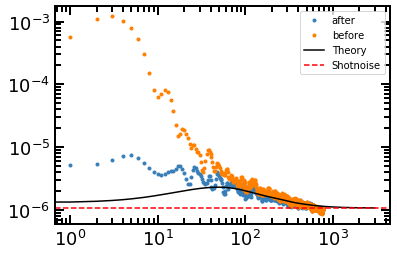

In [22]:
for name, cl_i in cl_obs.items():
    plt.plot(cl_i/fsky, marker='.', ls='None', label=name)
plt.plot(cl_true+1./nbar_sr, 'k-', label='Theory')
plt.axhline(1./nbar_sr, ls='--', color='r', label='Shotnoise')
plt.loglog()
plt.legend(fontsize=10)
# plt.xlim(xmin=50.)
# plt.ylim(0.0, 5.0e-6)

In [31]:
np.savez('/home/mehdi/data/dr9v0.57.0/p38fnl/cl_qso_bzmls.npz', 
        **{**cl_obs, 'nbar_sr':nbar_sr, 'cl_true':cl_true, 'fsky':fsky})

### Creation of Mocks

In [62]:
cls = np.load('/home/mehdi/data/dr9v0.57.0/p38fnl/cl_qso_bzmls.npz', allow_pickle=True)
cls.files

['after', 'before', 'nbar_sr', 'cl_true', 'fsky']

In [63]:
nside = 256
cl_true = cls['cl_true']
nbar_sr = cls['nbar_sr']
fsky = cls['fsky']

Text(0, 0.5, 'C$_{\\ell}$')

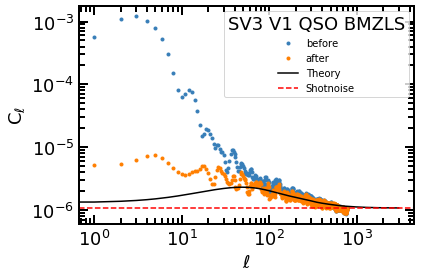

In [66]:
for name in ['before', 'after']:
    plt.plot(cls[name]/fsky, marker='.', ls='None', label=name)
plt.plot(cl_true+1./nbar_sr, 'k-', label='Theory')
plt.axhline(1./nbar_sr, ls='--', color='r', label='Shotnoise')
plt.loglog()
plt.legend(fontsize=10, title='SV3 V1 QSO BMZLS')
# plt.xlim(xmin=50.)
# plt.ylim(0.0, 5.0e-6)
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')

In [43]:
delta_g = hp.synfast(cl_true, nside=nside, pol=False, verbose=False)

# approach B
noise_g = hp.synfast(np.ones_like(cl_true)/nbar_sr, nside=nside, pol=False, verbose=False)

# approach A
# n_g_ = nbar_sr*(1+delta_g) # per pixel
# n_g = Poisson(n_g_) 

# Following B ->
# n_g = Round(nbar_sr*(1+delta_g+noise_g))

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1196: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/projaxes.py:1155: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if matplotlib.cbook.iterable(value):


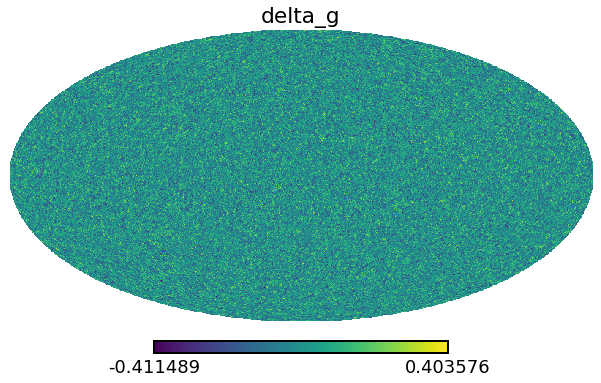

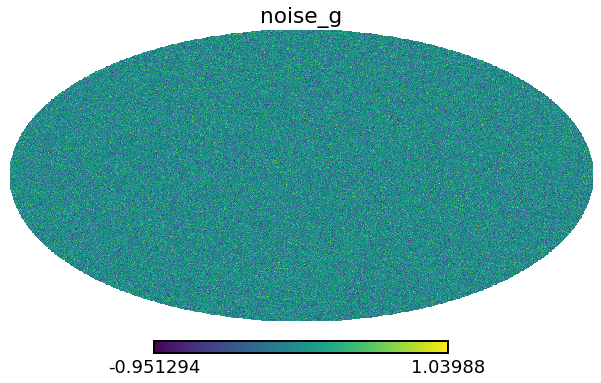

In [10]:
hp.mollview(delta_g, title='delta_g')
hp.mollview(noise_g, title='noise_g')

In [44]:
cl_noise = run_anafast(noise_g, np.ones_like(delta_mock, '?'))

In [45]:
delta_mock = delta_g + noise_g

In [46]:
cl_mock = run_anafast(delta_mock, np.ones_like(delta_mock, '?'))

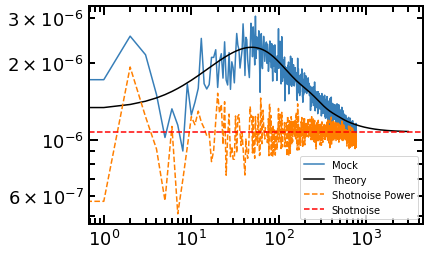

In [47]:
plt.plot(cl_mock, label='Mock')
plt.plot(cl_true+1./nbar_sr, 'k-', label='Theory')
plt.plot(cl_noise, label='Shotnoise Power')
plt.axhline(1./nbar_sr, ls='--', color='r', label='Shotnoise')

plt.loglog()
plt.legend(fontsize=10)

In [27]:
mock_dir = '/home/mehdi/data/dr9v0.57.0/p38fnl/data/mocks/'

nmocks = 100
np.random.seed(85)
seeds = np.random.randint(0, 2**32-1, size=nmocks)
seeds = np.unique(seeds)
print(len(seeds))

for i in range(1,nmocks+1):
    mock_i = os.path.join(mock_dir, f'{i:03d}.hp.fits')
    #print(seeds[i-1], mock_i)

    np.random.seed(seeds[i-1])
    
    delta_g = hp.synfast(cl_true, nside=nside, pol=False, verbose=False)
    noise_g = hp.synfast(np.ones_like(cl_true)/nbar_sr, nside=nside, pol=False, verbose=False)
    
    delta_mock = delta_g + noise_g
    hp.write_map(mock_i, delta_mock, fits_IDL=False, dtype=np.float64, overwrite=True)
    print('.', end='')

100
....................................................................................................

In [16]:
region = 'NBMZLS'
dcat_ = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/sv3target_QSO_{region}.fits')
rcat_ = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/{region}_randoms-1-0x5.fits')
wsys_ = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/sv3target_QSO_{region}.fits_EdWsys/wsys_v0.fits')['wsys']

bits = [1, 5, 6, 7, 8, 9, 11, 12, 13] # https://www.legacysurvey.org/dr9/bitmasks/
dcat, ix = ut.cutphotmask(dcat_, bits, return_indices=True)
rcat = ut.cutphotmask(rcat_, bits)
wsys = wsys_[ix]

1629292 before imaging veto
1512178 0.928119698617559 after imaging veto
64410796 before imaging veto
58377274 0.9063274734254176 after imaging veto


In [17]:
nside = 256
dhp = ut.hpixsum(nside, dcat['RA'], dcat['DEC'], weights=wsys)
dhp_ = ut.hpixsum(nside, dcat['RA'], dcat['DEC'])*1.0
rhp = ut.hpixsum(nside, rcat['RA'], rcat['DEC'])*1.0

In [23]:
mask_ = '/home/mehdi/data/dr9v0.57.0/p38fnl/data/mask_bmzls.hp.fits'
templ_ = '/home/mehdi/data/templates/dr9/pixweight_dark_dr9m_nside256.h5'

In [24]:
#--- read templates
templ = pd.read_hdf(templ_)
templ_np = templ[maps_dr9sv3].values

# --- read mask
mask = hp.read_map(mask_) > 0.5
mask_sysm = (~np.isfinite(templ_np)).sum(axis=1) < 1
mask &= mask_sysm

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [25]:
cl_wsys = get_cl(dhp, rhp, mask, systematics=templ_np, njack=0)
cl_now = get_cl(dhp_, rhp, mask, systematics=templ_np, njack=0)

In [26]:
np.savez('/home/mehdi/data/dr9v0.57.0/p38fnl/clxsys_qso_bzmls.npz', 
        **{'wsys':cl_wsys, 'wosys':cl_now})

In [6]:
cl_obs = np.load('/home/mehdi/data/dr9v0.57.0/p38fnl/clxsys_qso_bzmls.npz', allow_pickle=True)
cl_obs.files

['wsys', 'wosys']

In [15]:
cl_wsys = cl_obs['wsys'].item()
cl_now = cl_obs['wosys'].item()

In [8]:
cl_mock = np.load('/home/mehdi/data/dr9v0.57.0/p38fnl/data/mocks/cl/cl_001.npz', allow_pickle=True)

In [18]:
cl_mock.files

['cl_gg', 'cl_sg']

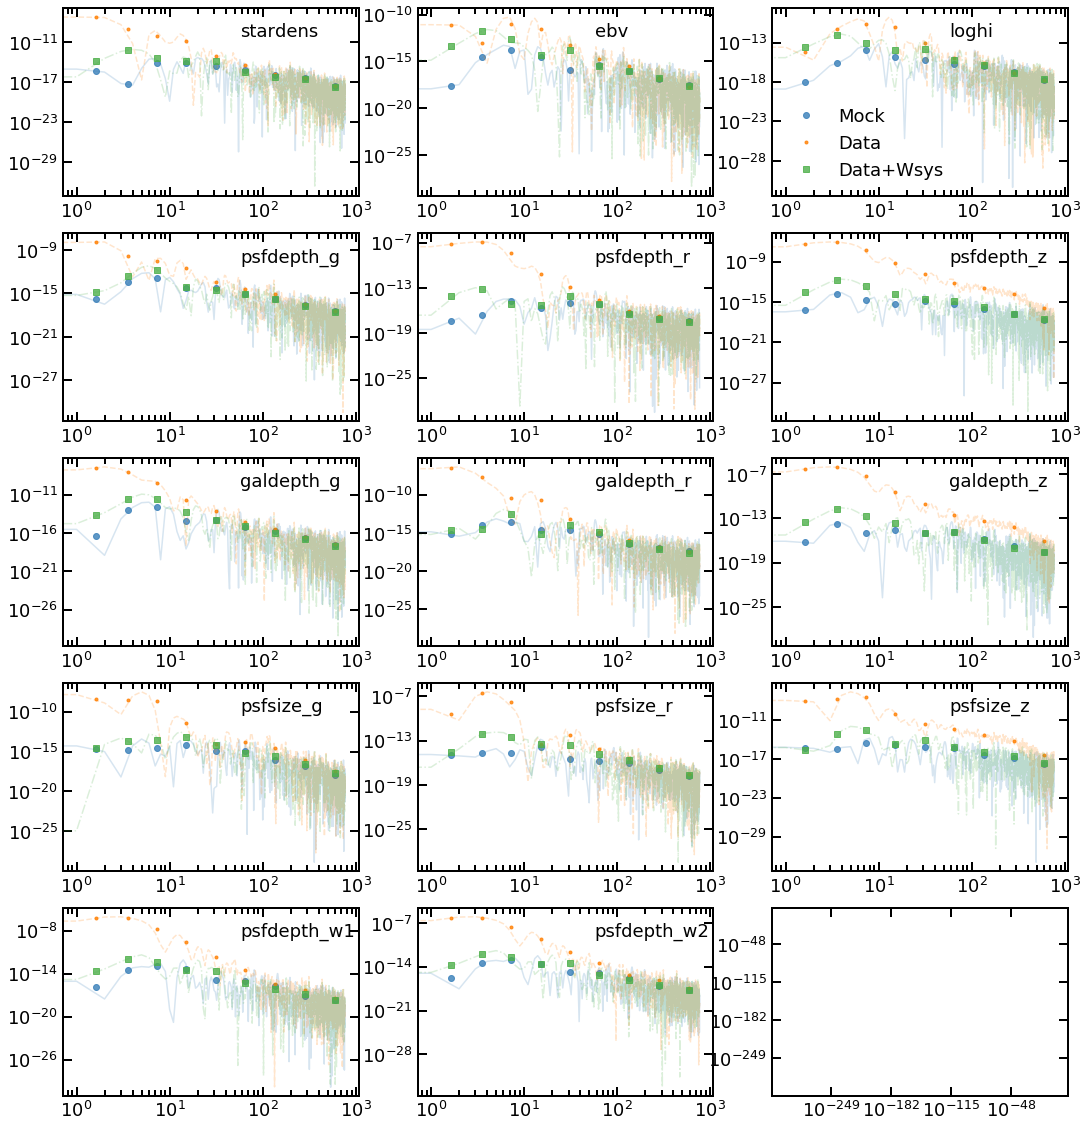

In [16]:
fg, ax = plt.subplots(ncols=3, nrows=5, figsize=(18, 20))

ax = ax.flatten()

markers = ['o', '.', 's']

for i in range(14):
    ax[i].text(0.6, 0.85, maps_dr9sv3[i], transform=ax[i].transAxes)
    
    j = 0
    for cl_i, name_i in zip([cl_mock, cl_now, cl_wsys],
                            ['Mock', 'Data', 'Data+Wsys']):
        
        cl_ = cl_i['cl_sg'][i]['cl']**2/cl_wsys['cl_ss'][i]['cl']
        lb, clb = histogram_cell(cl_)
        line, = ax[i].plot(cl_**2, alpha=0.2)
        ax[i].plot(lb, clb**2, color=line.get_color(), ls='None', 
                   marker=markers[j], label=name_i, alpha=0.8)
        j += 1
        
for axi in ax:
    
    axi.set_yscale('log')
    axi.set_xscale('log')
    
ax[2].legend(frameon=False)

In [53]:
def chi2_fn(y, invcov):
    return np.dot(y, np.dot(invcov, y))    

def read_cl(fn, ix=[i for i in range(17)], colmax=None, kind='wsys'):

    cl = np.load(fn, allow_pickle=True)[kind].item()
    cl_cross = []
    cl_ss = []

    for i in ix:    
        l_, cl_sg_ = histogram_cell(cl['cl_sg'][i]['cl'])
        l_, cl_ss_ = histogram_cell(cl['cl_ss'][i]['cl'])

        cl_ss.append(cl_ss_)
        cl_cross.append(cl_sg_[:colmax]**2/cl_ss_[:colmax])    

    return l_[:colmax], np.array(cl_cross), cl_ss

def read_clmocks(fn, cl_ss, ix=np.arange(14), colmax=None):
    cl = np.load(fn, allow_pickle=True)
    cl_cross = []

    for i in ix:    
        l_, cl_sg_ = histogram_cell(cl['cl_sg'][i]['cl'])
        cl_ss_ = cl_ss[i]
        cl_cross.append(cl_sg_[:colmax]**2/cl_ss_[:colmax])    

    return l_[:colmax], np.array(cl_cross)

def get_chi2mocks(cl_sys, colmax):

    # mocks
    p = '/home/mehdi/data/dr9v0.57.0/p38fnl/data/mocks/cl/cl_*.npz'
    mocks = glob(p)
    print(len(mocks))

    clmocks = []
    for mock_i in mocks:
        clmock_ = read_clmocks(mock_i, cl_sys, colmax=colmax)[1]
        clmocks.append(clmock_.flatten())
    err_tot = np.array(clmocks)
    nmocks, nbins = err_tot.shape
    hartlapf = (nmocks-1. - 1.) / (nmocks-1. - nbins - 2.)
    indices = [i for i in range(nmocks)]

    # chi2 of mocks
    chi2s = []
    for i in range(nmocks):
        indices_ = indices.copy()    
        indices_.pop(i)

        nbar_ = err_tot[i, :]
        err_ = err_tot[indices_, :]    
        covmax_ = np.cov(err_, rowvar=False)
        invcov_ = np.linalg.inv(covmax_*hartlapf)

        chi2_ = chi2_fn(nbar_, invcov_)
        chi2s.append(chi2_)  
    chi2mocks = np.array(chi2s)        
    print(np.percentile(chi2mocks, [0, 1, 5, 95, 99, 100]))

    # chi2 of data    
    covmax_ = np.cov(err_tot, rowvar=False)
    hartlapf = (nmocks - 1.) / (nmocks - nbins - 2.)
    invcov_ = np.linalg.inv(covmax_*hartlapf)       
    return chi2mocks, invcov_

In [54]:
cl_data = {}
cl_data['wsys'] = read_cl('/home/mehdi/data/dr9v0.57.0/p38fnl/clxsys_qso_bzmls.npz', ix=np.arange(14), colmax=6, kind='wsys')
cl_data['wosys'] = read_cl('/home/mehdi/data/dr9v0.57.0/p38fnl/clxsys_qso_bzmls.npz', ix=np.arange(14), colmax=6, kind='wosys')

In [55]:
chi2mocks, invcov = get_chi2mocks(cl_data['wosys'][2], 6)

100
[ 15.72515174  26.84962307  36.42509055 215.3364413  377.44692426
 403.23702598]


In [56]:
chi2_data = {}
for n, cl_i in cl_data.items():
    chi2_data[n] = chi2_fn(cl_i[1].flatten(), invcov)

In [57]:
chi2_data

{'wsys': 791.5599215348415, 'wosys': 811352713.8704612}

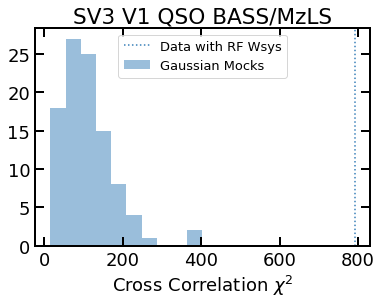

In [61]:
plt.hist(chi2mocks, alpha=0.5, label='Gaussian Mocks')
plt.axvline(chi2_data['wsys'], ls=':', label='Data with RF Wsys')
plt.xlabel(r'Cross Correlation $\chi^{2}$')
plt.title('SV3 V1 QSO BASS/MzLS')
plt.legend(fontsize=13)

In [2]:
# calculate 2D angular auto and cross power spectra
# calculate 1D mean density
target = 'LRG'
region = 'NBMZLS'
dcat_ = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/sv3target_{target}_{region}.fits')
# rcat_ = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/{region}_randoms-1-0x5.fits')
# wsys_ = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/sv3target_QSO_{region}.fits_MrWsys/wsys_v1.fits')['wsys']

bits = [1, 5, 6, 7, 8, 9, 11, 12, 13]                         # https://www.legacysurvey.org/dr9/bitmasks/
dcat, ix = ut.cutphotmask(dcat_, bits, return_indices=True)   #
# rcat = ut.cutphotmask(rcat_, bits)
# wsys = wsys_[ix]

# wsys_ed = ft.read(f'/home/mehdi/data/dr9v0.57.0/sv3_v1/sv3target_QSO_{region}.fits_EdWsys/wsys_v0.fits')['wsys']
# wsys_ed = wsys_ed[ix]

4214818 before imaging veto
3750922 0.8899368845819677 after imaging veto


In [3]:
nside = 256
# dhp = ut.hpixsum(nside, dcat['RA'], dcat['DEC'], weights=wsys)
dhp_ = ut.hpixsum(nside, dcat['RA'], dcat['DEC'])*1.0
# rhp = ut.hpixsum(nside, rcat['RA'], rcat['DEC'])*1.0
# dhp_ed = ut.hpixsum(nside, dcat['RA'], dcat['DEC'], weights=wsys_ed)
# mask = rhp > 0

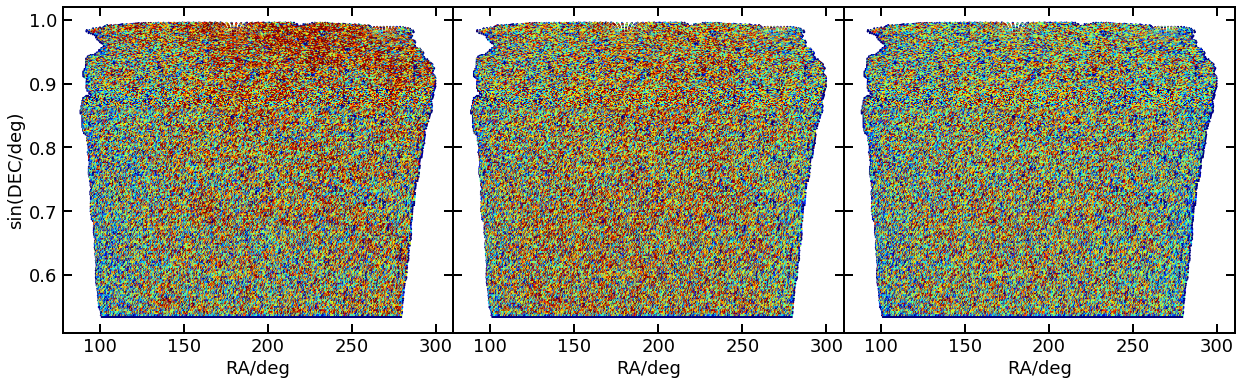

In [102]:
ra, dec = ut.hpix2radec(256, np.argwhere(mask).flatten())
sdec = np.sin(np.radians(dec))
fg, ax = plt.subplots(ncols=3, sharey=True, figsize=(21, 6))
fg.subplots_adjust(wspace=0.0)

ax[0].scatter(ra, sdec, 1, c=dhp_[mask], marker='h', vmin=8, vmax=20, cmap=plt.cm.jet)
ax[1].scatter(ra, sdec, 1, c=dhp[mask], marker='h', vmin=8, vmax=20, cmap=plt.cm.jet)
ax[2].scatter(ra, sdec, 1, c=dhp_ed[mask], marker='h', vmin=8, vmax=20, cmap=plt.cm.jet)

ax[0].set(ylabel='sin(DEC/deg)')
for axi in ax:axi.set(xlabel='RA/deg')

In [17]:
from lssutils.utils import NNWeight

In [22]:
nn = NNWeight('/home/mehdi/data/dr9v0.57.0/sv3nn_v1/regression/v1/sv3nn_LRG_NBMZLS_256/nn-weights.fits', 256, aggregate='none', ix=2)

use 2


In [12]:
# for map_i in [nn.wmap]: # , dhp_, nlrg
#     print()

[13.51873703 17.93616447]


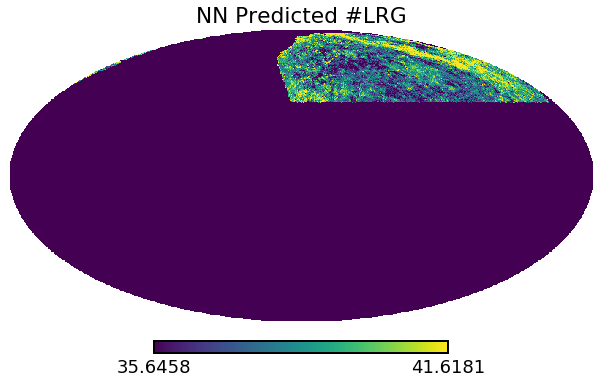

In [23]:
vmin, vmax = np.percentile(nn.wmap[nn.mask], [5, 95])

hp.mollview(nn.wmap, rot=-85, min=vmin, max=vmax, title='NN Predicted #LRG')

In [2]:
import fitsio as ft
import sys
sys.path.append('/home/mehdi/github/LSSutils')
from lssutils.utils import make_hp
sys.path.append('/home/mehdi/github/sysnetdev')
from sysnet import TrainedModel
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
%matplotlib inline

In [17]:
from glob import glob

In [18]:
models = glob('/home/mehdi/data/rongpu/imaging_sys/regression/v2/sv3nn_lrg_bmzls_256/model*/best.pth.tar')
len(models)

96

In [19]:
maps_nn = []

for path_model in models:
    
    name_model = 'dnn'
    #path_model = '/home/mehdi/data/rongpu/imaging_sys/regression/v2/sv3nn_lrg_bmzls_256/model_2_3206879803/best.pth.tar'
    kw_model = dict(nnstruct=(4, 20), num_features=13)

    tm = TrainedModel(name_model, path_model, **kw_model)
    hpix, npred = tm.forward('/home/mehdi/data/rongpu/imaging_sys/tables/nlrg_features_bmzls_256.fits') 

    map_ = np.zeros(12*256**2)
    map_[hpix] = npred
    map_n = map_ / map_[hpix].mean()
    map_n = map_n.clip(0.5, 2.0)
    
    maps_nn.append(map_n)
    print('.', end='')

................................................................................................

In [22]:
np.array(maps_nn).shape

(96, 786432)

In [5]:
dl = ft.read('/home/mehdi/data/rongpu/imaging_sys/tables/nlrg_features_bmzls_256.fits')
nlrg = make_hp(256, dl['hpix'], dl['label'], True)
frac = make_hp(256, dl['hpix'], dl['fracgood'])
mask = frac > 0.0
mask.sum(), len(hpix)

(97775, 97775)

In [6]:
from lssutils.stats.nnbar import MeanDensity
from scipy.stats import pearsonr

In [21]:
for i in range(13):
    print(i, pearsonr(dl['label'], dl['features'][:, i]))

0 (-0.0609979112395234, 3.0016153329383107e-81)
1 (-0.10414968283551845, 6.810174894845989e-234)
2 (0.06770678610424845, 1.0556023672298127e-99)
3 (0.07444407226312397, 3.513177615116449e-120)
4 (0.06412573396138835, 1.3000636337621176e-89)
5 (0.07092870939066358, 2.97995145048864e-109)
6 (0.06673347297327985, 6.61482311540203e-97)
7 (0.058020380531894435, 1.1210508557940665e-73)
8 (-0.013369492994524156, 2.9069057429357835e-05)
9 (-0.022598643541436883, 1.5811307802271358e-12)
10 (-0.034287835753997374, 7.812739627012168e-27)
11 (0.013542778654408536, 2.2872393702535302e-05)
12 (-0.011774339181632405, 0.00023159489548171868)


In [8]:
syst = make_hp(256, dl['hpix'], dl['features'][:, 1])

In [9]:
bins = np.linspace(*np.percentile(syst[mask], [5, 95]), 9)

In [10]:
bins

array([ 305.0184021 ,  583.82426834,  862.63013458, 1141.43600082,
       1420.24186707, 1699.04773331, 1977.85359955, 2256.65946579,
       2535.46533203])

In [33]:
kw = dict(binning='simple', bins=bins)


nbar_ob = MeanDensity(nlrg, frac, mask, syst, **kw)
nbar_ob.run()

nbar_models = []
nbar_wsys = []

for map_i in maps_nn:
    
    nbar_model = MeanDensity(map_i*frac, frac, mask, syst, **kw)
    nbar_model.run()
    nbar_models.append(nbar_model.output)
    
    nbar_wsys_ = MeanDensity(nlrg, frac, mask, syst, selection=map_i, **kw)
    nbar_wsys_.run()
    nbar_wsys.append(nbar_wsys_.output)
    print('.', end='')

...............................................................................................

In [34]:
## 
2

2

In [44]:
from lssutils.dataviz import setup_color

In [45]:
setup_color()

In [49]:
from lssutils.dataviz import mollview, mycolor

(array([6.88657e+05, 1.50000e+01, 1.48450e+04, 7.86500e+04, 4.14800e+03,
        1.13000e+02, 3.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([0.5 , 0.65, 0.8 , 0.95, 1.1 , 1.25, 1.4 , 1.55, 1.7 , 1.85, 2.  ]),
 <a list of 10 Patch objects>)

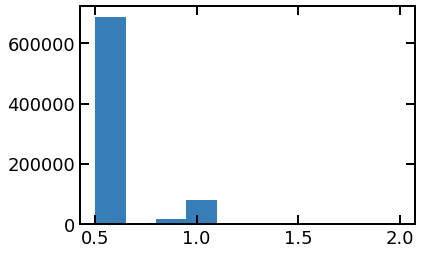

In [55]:
plt.hist(maps_nn[0])

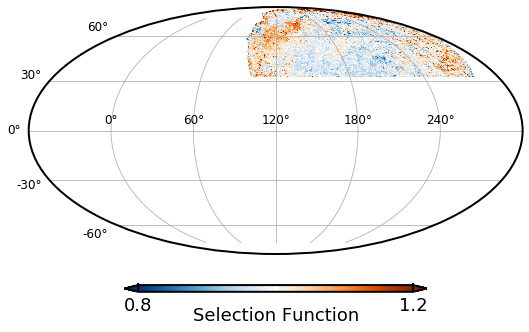

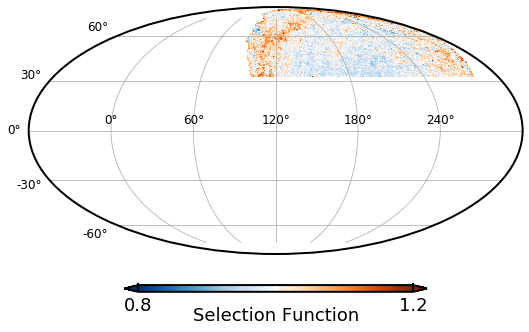

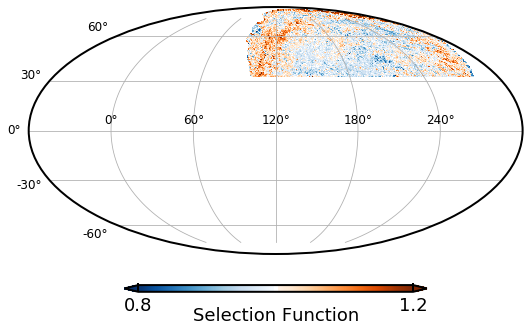

In [62]:
for i in range(3):
    map_one = maps_nn[i].copy()
    map_one[~mask] = np.nan
    mollview(map_one, 0.8, 1.2, 'Selection Function', cmap=mycolor(), colorbar=True, )

Text(0, 0.5, 'Mean Density')

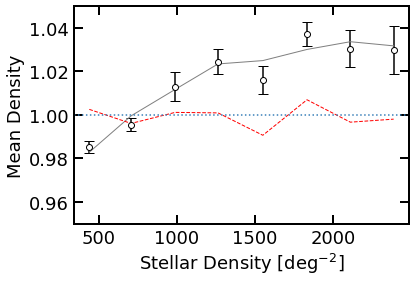

In [46]:
plt.errorbar(nbar_ob.output['bin_avg'], nbar_ob.output['nnbar'], nbar_ob.output['nnbar_err'],
            capsize=5, marker='o', mfc='w', ls='None', color='k', label='Data (Observed)')

for i in range(1):
    plt.plot(nbar_models[i]['bin_avg'], nbar_models[i]['nnbar'], color='grey', lw=1)
    plt.plot(nbar_wsys[i]['bin_avg'], nbar_wsys[i]['nnbar'], color='r', lw=1)

plt.ylim(0.95, 1.05)
plt.axhline(1.0, ls=':')
plt.xlabel(r'Stellar Density [deg$^{-2}$]')
plt.ylabel('Mean Density')

Text(0, 0.5, 'Mean Density')

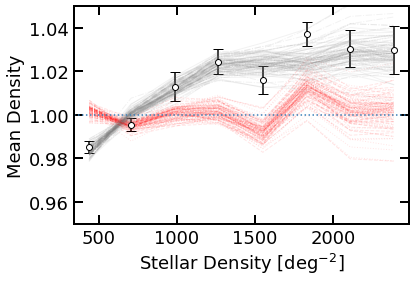

In [65]:
plt.errorbar(nbar_ob.output['bin_avg'], nbar_ob.output['nnbar'], nbar_ob.output['nnbar_err'],
            capsize=5, marker='o', mfc='w', ls='None', color='k', label='Data (Observed)')

for i in range(len(nbar_models)):
    plt.plot(nbar_models[i]['bin_avg'], nbar_models[i]['nnbar'], color='grey', alpha=0.1, lw=1)
    plt.plot(nbar_wsys[i]['bin_avg'], nbar_wsys[i]['nnbar'], color='r', alpha=0.1, lw=1)

plt.ylim(0.95, 1.05)
plt.axhline(1.0, ls=':')
plt.xlabel(r'Stellar Density [deg$^{-2}$]')
plt.ylabel('Mean Density')

In [67]:
from lssutils.stats.cl import AnaFast

In [69]:
from lssutils.utils import make_overdensity

In [68]:
af = AnaFast()

In [70]:
delta_obs = make_overdensity(nlrg, frac, mask)

In [71]:
cl_obs = af(delta_obs, frac, mask)

In [74]:
cl_wsys = []
for map_i in maps_nn:
    #print(map_i.shape)
    delta_i = make_overdensity(nlrg, frac, mask, selection_fn=map_i)
    cl_wsys.append(af(delta_i, frac, mask))
    print('.', end='')

................................................................................................

Text(0, 0.5, 'C$_{\\ell}$')

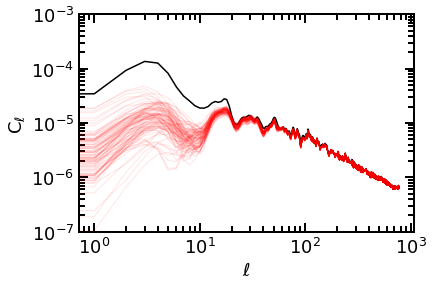

In [83]:
plt.loglog(cl_obs['cl'], color='k')

for cl_wsysi in cl_wsys:
    plt.loglog(cl_wsysi['cl'], color='r', alpha=0.1, lw=1, ls='-')

plt.ylim(1.0e-7, 1.0e-3)
plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{\ell}$')

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('/home/mehdi/github/LSSutils')
from lssutils.dataviz import setup_color

In [3]:
setup_color()

In [8]:
def plot_nnbar(reg):
    
    d = np.load(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{reg}_256_noweight.npy', allow_pickle=True)
    dn = np.load(f'/home/mehdi/data/rongpu/imaging_sys/clustering/v2/nbar_lrg_{reg}_256_nn.npy', allow_pickle=True)

    fg, ax = plt.subplots(ncols=5, nrows=3, figsize=(30, 12), sharey=True)
    fg.subplots_adjust(wspace=0.0, hspace=0.3)

    ax = ax.flatten()

    for i, di in enumerate(d):
        ax[i].errorbar(di['bin_avg'], di['nnbar'], di['nnbar_err'], capsize=3)
        ax[i].plot(dn[i]['bin_avg'], dn[i]['nnbar'])

        ax[i].set(xlabel=di['sys'])
        
    ax[2].set_title(reg.upper())

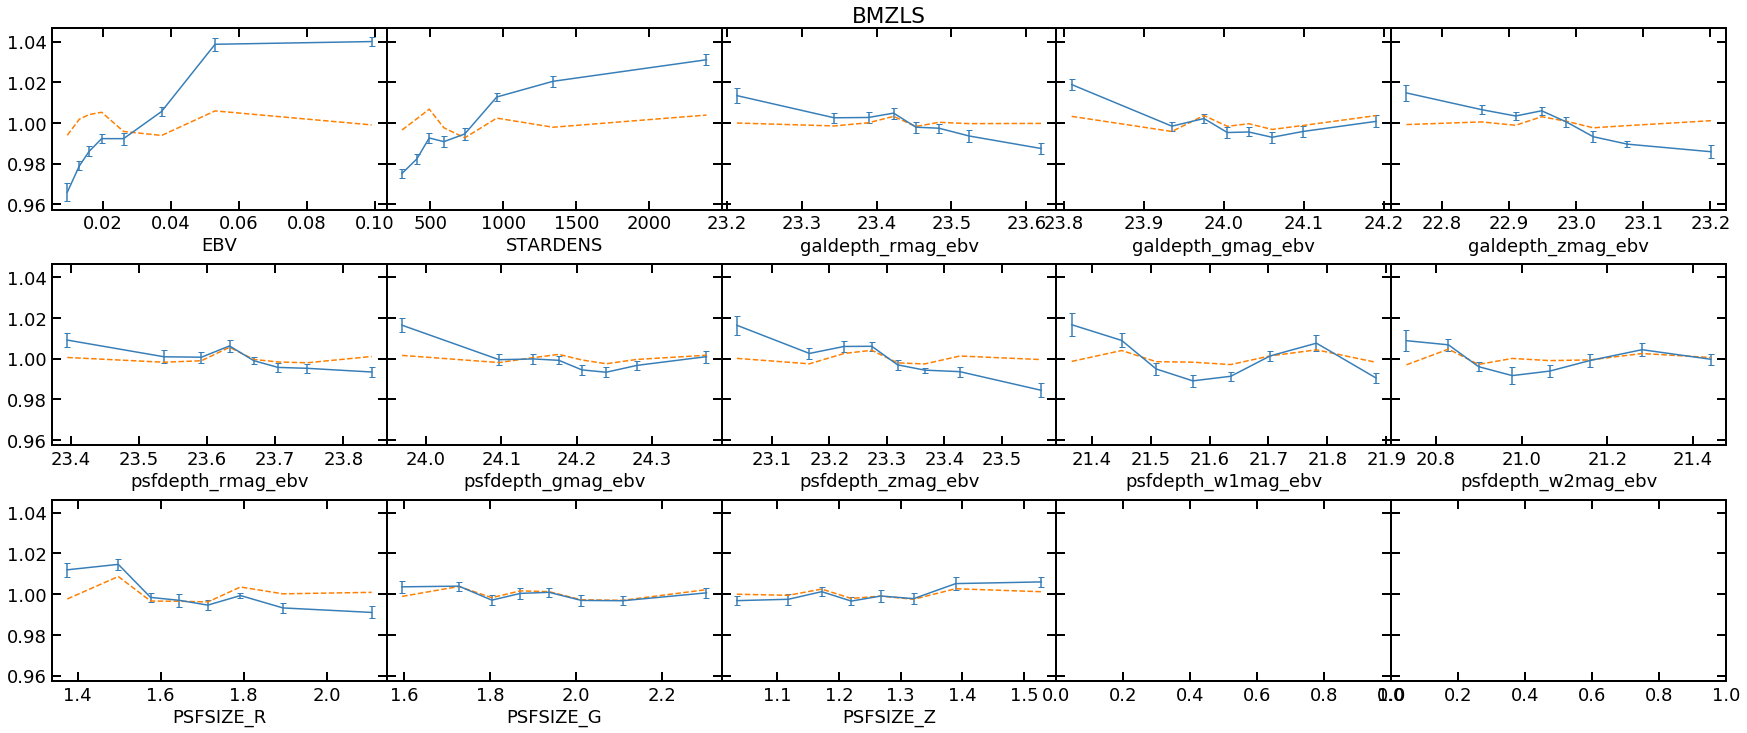

In [9]:
plot_nnbar('bmzls')

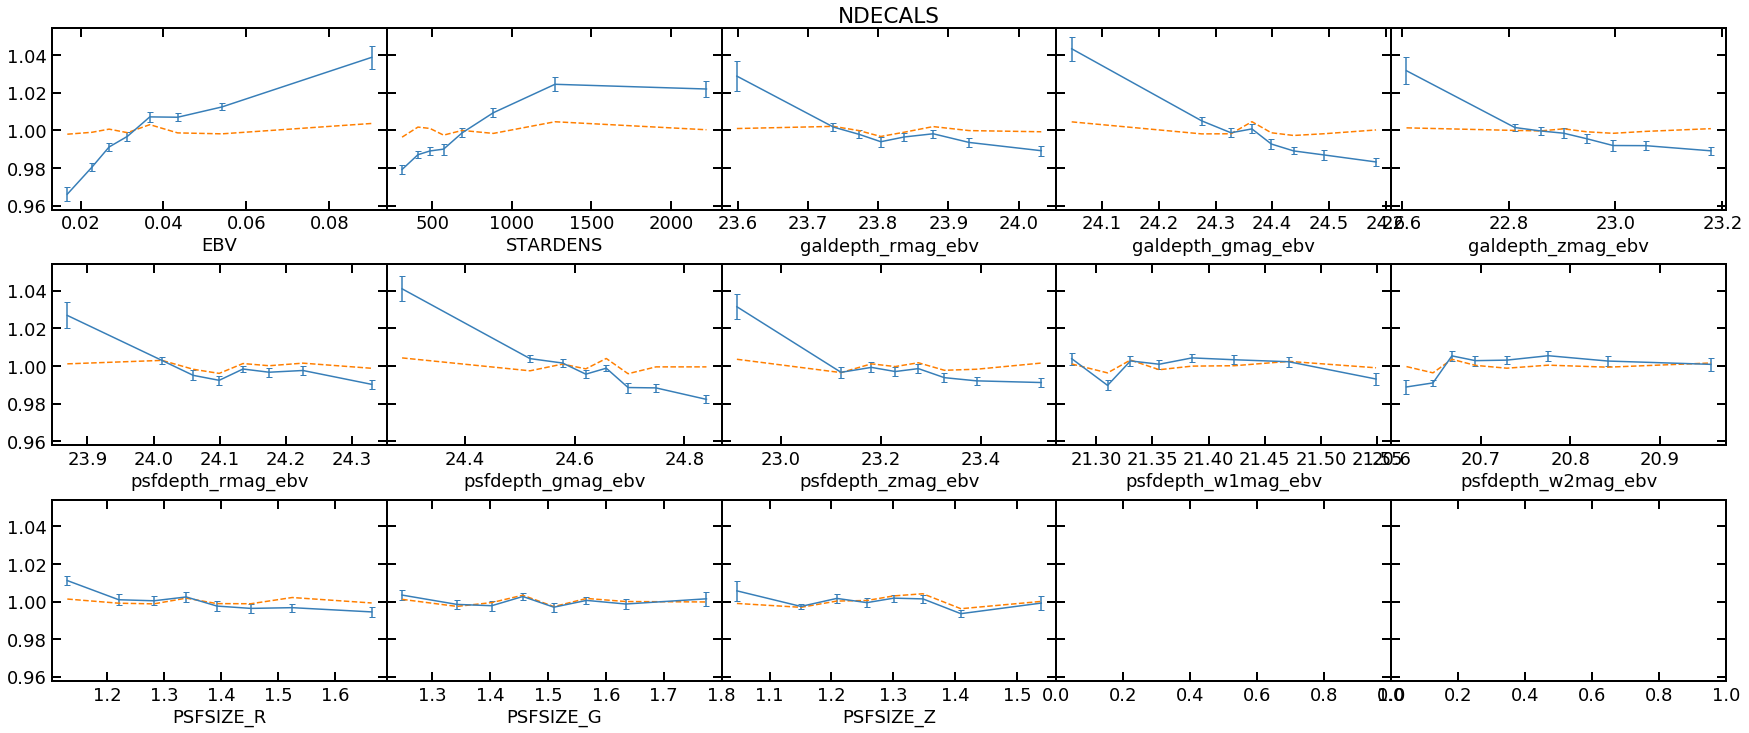

In [10]:
plot_nnbar('ndecals')

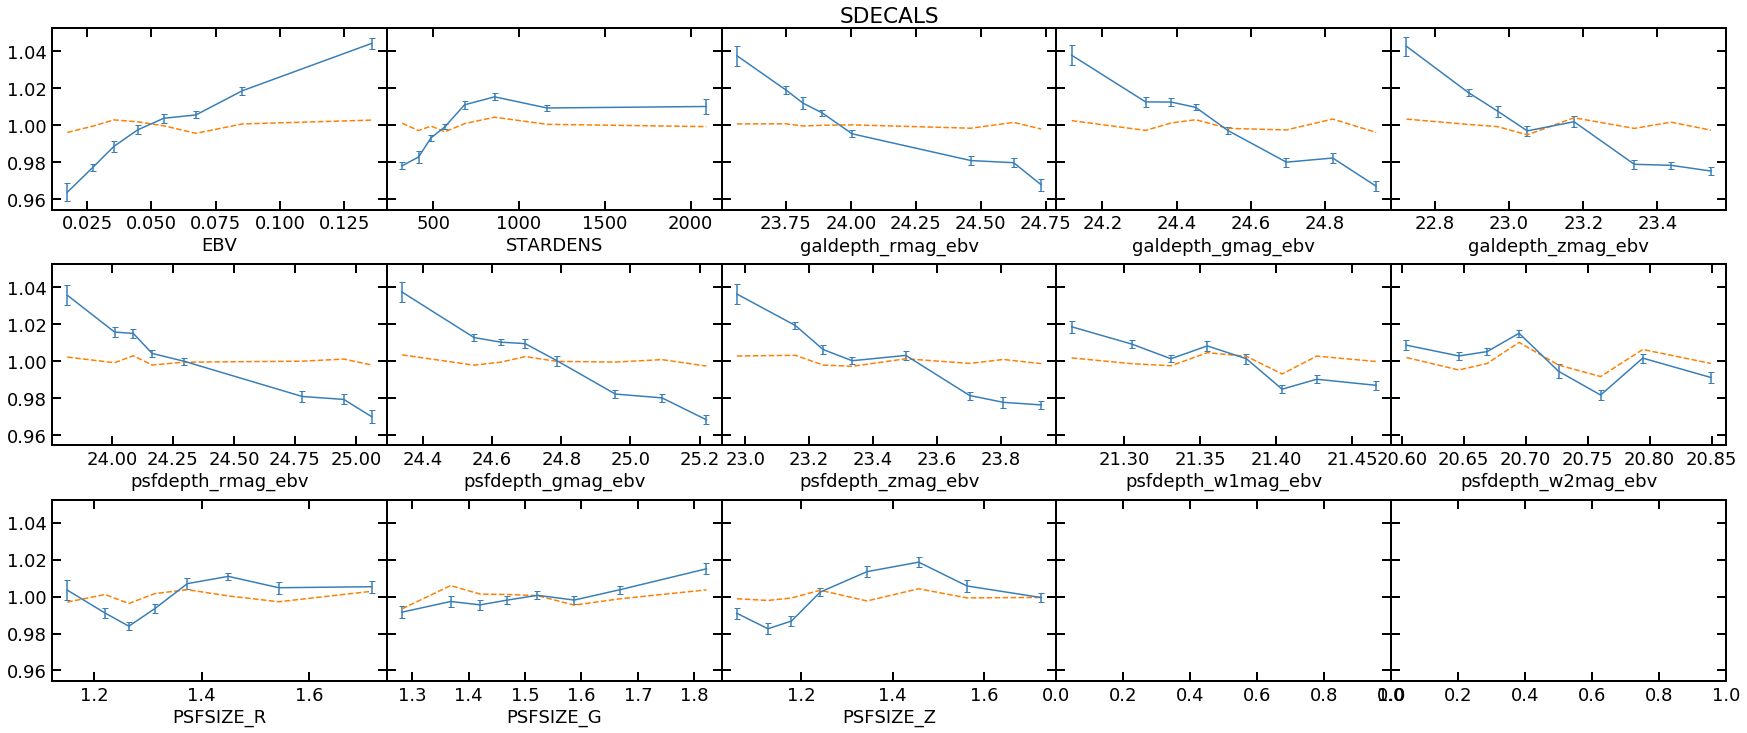

In [11]:
plot_nnbar('sdecals')